In [1]:
image = 'laundry_cat.jpg'
scaling_factor = 25

In [2]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import spatial
import math
import random
import queue

In [3]:
Ursa = cv2.imread(image)
Ursa = cv2.cvtColor(Ursa, cv2.COLOR_BGR2RGB)

In [4]:
new_height = Ursa.shape[0] // scaling_factor
new_width = Ursa.shape[1] // scaling_factor

In [5]:
Ursa_small = cv2.resize(Ursa, (new_width, new_height))

In [6]:
colors = pd.read_csv('DMC to RBG.csv')

In [7]:
color_dict = {}
color_list = []
for index, row in colors.iterrows():
    color_dict[(row['R'], row['G'], row['B'])] = (row['Floss'], row['DMC Name'])
    color_list.append((row['R'], row['G'], row['B']))

In [8]:
tree = spatial.KDTree(color_list) 

In [9]:
pattern = np.zeros(Ursa_small.shape).astype(np.uint8)

In [10]:
for i in range(new_height):
    for j in range(new_width):
        distance, nearest_color = tree.query(Ursa_small[i, j])
        pattern[i, j] = color_list[nearest_color]

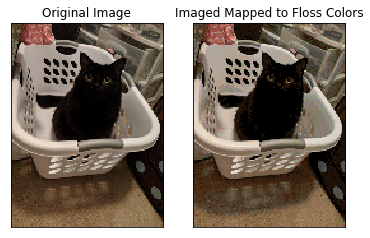

In [11]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(Ursa_small)
axes[0].set_title('Original Image'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(pattern)
axes[1].set_title('Imaged Mapped to Floss Colors'), axes[1].set_xticks([]), axes[1].set_yticks([]);

In [12]:
def get_neighbors(m, x, y, theta):
    if theta[y, x] > math.pi/4:
        if y > 0 and y < m.shape[0] - 1:
            return (m[y + 1, x], m[y - 1, x])
        elif y == 0:
            return tuple([m[y + 1, x]])
        else: 
            return tuple([m[y - 1, x]])
    elif theta[y, x] < math.pi/4:
        if x > 0 and x < m.shape[1] - 1:
            return (m[y, x + 1], m[y, x - 1])
        elif x == 0:
            return tuple([m[y, x + 1]])
        else: 
            return tuple([m[y, x - 1]])

In [13]:
def check_maximum_pixel(m, theta, x, y):
    neighbors = get_neighbors(m, x, y, theta)
    if m[y, x] > max(neighbors):
        return 1
    else:
        return 0 

In [14]:
def get_neighboring_pixels(y, x, height, width):
    neighbors = []
    if y > 0: 
        neighbors.append((y - 1, x))
    if x > 0:
        neighbors.append((y, x - 1))
    if y < height - 1:
        neighbors.append((y + 1, x))
    if x < width - 1:
        neighbors.append((y, x + 1))
    return neighbors

In [15]:
def canny_edge_detection(img, t1, t2, blur_kernal_size = 3):
    img = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #step 1: blur
    blur = cv2.GaussianBlur(img,(blur_kernal_size,blur_kernal_size),0)
    
    #step 2: compute gradients
    kernalx = np.array([[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]])
    kernaly = np.array([[ 1,  2,  1], 
                        [ 0,  0,  0],
                        [-1, -2, -1]])

    
    gx = cv2.filter2D(blur, -1, kernalx)
    gy = cv2.filter2D(blur, -1, kernaly)
    
    #m = np.sqrt(np.square(gx) + np.square(gy))
    m = np.hypot(gx, gy)
    theta = np.arctan2(gy, gx) 
    
    #step 3: apply threshold
    lines1 = np.where(m > t1, 1, 0)
    lines2 = np.where(m > t2, 1, 0)
    
    #step 4: suppress non-maxima pixels
    for y in range(m.shape[0]):
        for x in range(m.shape[1]):
            is_max = check_maximum_pixel(m, theta, x, y)
            if lines1[y, x] == 1:
                lines1[y, x] = is_max
            if lines2[y, x] == 1:
                lines2[y, x] = is_max
    
    #step 6: 
    
    outlines = lines2.copy()
    
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if 1 == 1:
                if lines2[y, x] == 1:
                    visited = set([])
                    segment = [(y, x)]
                    search = queue.Queue()
                    search.put(segment)
                    while not search.empty():
                        line = search.get()
                        neighbors = get_neighboring_pixels(line[-1][0], line[-1][1], img.shape[0], img.shape[1])
                        for neighbor in neighbors:
                            if neighbor not in visited:
                                visited.add(neighbor)
                                if lines2[neighbor[0], neighbor[1]] == 1:
                                    for pixel in line:
                                        outlines[pixel[0],pixel[1]] = 1
                                elif lines1[neighbor[0], neighbor[1]] == 1:
                                    line2 = line.copy()
                                    line2.append(neighbor)
                                    search.put(line2)
    
    # Figuring out which side of the pixel to add the backstitch to
    backstitch = []
    
    for row in range(outlines.shape[0]):
        new_row = []
        for col in range(outlines.shape[1]):
            if outlines[row, col] == 1:
                neighbors = get_neighboring_pixels(row, col, outlines.shape[0], outlines.shape[1])
                to_check = []
                for neighbor in neighbors:
                    if outlines[neighbor[0], neighbor[1]] == 0:
                        to_check.append(neighbor)
                max_gradient = 0
                side = None
                for n in to_check:
                    gradient = abs(int(blur[n[0], n[1]]) - int(blur[row, col]))
                    if gradient > max_gradient:
                        max_gradient = gradient
                        if n[0] > row:
                            side = 'down'
                        elif n[0] < row:
                            side = 'up'
                        elif n[1] > col:
                            side = 'right'
                        else:
                            side = 'left'
                new_row.append(side)
            else:
                new_row.append('skip')
        backstitch.append(new_row)
                        
    return (outlines, backstitch)

In [16]:
outline, backstitch = canny_edge_detection(pattern, 50,100, 5)

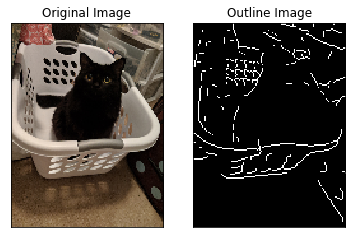

In [17]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(Ursa_small)
axes[0].set_title('Original Image'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(outline, cmap = 'gray')
axes[1].set_title('Outline Image'), axes[1].set_xticks([]), axes[1].set_yticks([]);

In [18]:
symbols = 'ABCDEFGHIJKLMNOPQRSTUVWXYZαβΓγΔδΕεζηΘΙιΛλμνΞξΟΠπΡΣσ/ςΤτΥυΦφΧΨΩω@#$%&*^<>?{[)(abcdefghijklmnopqrstuvwxyz123456789=+-†♥☻♦♣♠○◙♂♀♪♫►◄■☼⌂↔↕❀❁❂❈⚧✓♓♒♑♉♈♋⌘⌫✄✆✈✎✐⌛☎☏❆❅♁☽☄☁☂ϟ♮♭♙♘♖♕♔☜☝❤❥☣☯✞✘☢☠⓪①②③④⑤⑥⑦⑧⑨⑩◕◔◓◐☗◘◊➸➹➴₵＊'
symbols = list(symbols)
random.shuffle(symbols)

In [19]:
len(symbols)

204

In [20]:
colors = {}
itts = 0
symbol_pattern = []
for row in pattern:
    new_row = []
    for col in row:
        color = (col[0], col[1], col[2])
        if color not in colors:
            colors[color] = symbols[itts]
            itts += 1
        new_row.append(colors[color])
    symbol_pattern.append(new_row)

In [21]:
symbol_pattern_pd = pd.DataFrame(symbol_pattern)

In [22]:
key_dict ={}
for color in colors:
    key_dict[colors[color]] = color_dict[color]

In [23]:
key = pd.DataFrame(key_dict).transpose()
key.columns = ['number', 'color']
key = key.sort_values(by = 'number')

In [24]:
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
col_list = list(alphabet)
new_list = []
for i in col_list:
    for j in col_list:
        new_list.append(i + j)

col_list.extend(new_list)

In [25]:
writer_object = pd.ExcelWriter("pattern.xlsx", 
                        engine ='xlsxwriter')

symbol_pattern_pd.to_excel(writer_object, sheet_name='Pattern')
worksheet_object = writer_object.sheets['Pattern'] 
worksheet_object.set_column('A:ZZ', 3) 

workbook = writer_object.book

upper_border = workbook.add_format({'top' : 5})
lower_border = workbook.add_format({'bottom' : 5})
right_border = workbook.add_format({'right' : 5})
left_border = workbook.add_format({'left' : 5})


for row in range(len(backstitch)):
    for col in range(len(backstitch[0])):
        cell = col_list[col + 1] + str(row + 2)
        if backstitch[row][col] == 'up':
            worksheet_object.write(cell, symbol_pattern[row][col], upper_border)
        elif backstitch[row][col] == 'down':
            worksheet_object.write(cell, symbol_pattern[row][col], lower_border)
        elif backstitch[row][col] == 'left':
            worksheet_object.write(cell, symbol_pattern[row][col], left_border)
        elif backstitch[row][col] == 'right':
            worksheet_object.write(cell, symbol_pattern[row][col], right_border)
        

key.to_excel(writer_object, sheet_name = 'Key')

writer_object.save() 